In [20]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
url = 'https://clinicaltrials.gov/api/v2/studies'
params = {
    'format': 'json',
    'query.term': 'type 2 diabetes',
    'sort': 'StartDate:desc',
    'countTotal': 'true',
    'pageSize': 100
} 
headers = {
    'accept': 'application/json'
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

In [22]:
studies = data['studies']

In [23]:
records = []

for study in studies:
    ps = study.get('protocolSection', {})
    id_module = ps.get('identificationModule', {})

    id_num = id_module.get('nctId')
    title = id_module.get('briefTitle', 'MISSING')
    conditions = ', '.join(ps.get('conditionsModule', {}).get('conditions', []))

    # Flatten locations
    locations_raw = ps.get('contactsLocationsModule', {}).get('locations', [])
    location_strs = [
        ', '.join(filter(None, [
            loc.get('facility'),
            loc.get('city'),
            loc.get('state'),
            loc.get('country')
        ]))
        for loc in locations_raw
    ]
    locations = ' | '.join(location_strs) if location_strs else 'Location not listed'

    interventions_raw = ps.get('armsInterventionsModule', {}).get('interventions', [])
    for i in interventions_raw:
        name = i.get('name', '').strip()
        if name:
            records.append({
                'id_num': id_num,
                'title': title,
                'conditions': conditions,
                'intervention': name,
                'locations': locations
            })

# Convert to DataFrame and export
df = pd.DataFrame(records)
df.to_csv("trials_api.csv", index=False)


In [24]:
len(records)

173

In [25]:
for record in records[:3]:
    for key, value in record.items():
        print(f'{key}: {value}')
    print("-----")

id_num: NCT06560333
title: iSGLT2 Inhibitor and a iDPP -4 Inhibitor in Treatment of Type 2 Diabetes Mellitus in Patients Treated With Metformin (TRIAD)
conditions: Diabetes Mellitus, Type 2
intervention: N0892
locations: Eurofarma Laboratorios S.A, São Paulo, SP, Brazil
-----
id_num: NCT06560333
title: iSGLT2 Inhibitor and a iDPP -4 Inhibitor in Treatment of Type 2 Diabetes Mellitus in Patients Treated With Metformin (TRIAD)
conditions: Diabetes Mellitus, Type 2
intervention: Januvia® + Glifage XR® + Placebo
locations: Eurofarma Laboratorios S.A, São Paulo, SP, Brazil
-----
id_num: NCT06560333
title: iSGLT2 Inhibitor and a iDPP -4 Inhibitor in Treatment of Type 2 Diabetes Mellitus in Patients Treated With Metformin (TRIAD)
conditions: Diabetes Mellitus, Type 2
intervention: Forxiga® + Glifage XR® + Placebo
locations: Eurofarma Laboratorios S.A, São Paulo, SP, Brazil
-----


In [26]:
df["intervention"].value_counts()

Placebo                                               8
Saline                                                2
Routine Care                                          2
Usual Care                                            2
Standard of Care                                      2
                                                     ..
Participant Website                                   1
Digoxin 0.125 MG                                      1
FLEX-AP system will be implemented to T1D patients    1
Use of novel insulin injection port                   1
verapamil extended release capsule                    1
Name: intervention, Length: 161, dtype: int64

In [27]:
top_interventions = (
    df["intervention"]
    .dropna()
    .str.strip()
    .value_counts()
    .head(10)
)

print(top_interventions)

Placebo                                                        8
Saline                                                         2
Routine Care                                                   2
Usual Care                                                     2
Standard of Care                                               2
Exendin 9-39                                                   2
Limit Red Zone Foods                                           1
Disfrutando                                                    1
Mobile Health (mHealth) Patient-Reported Outcome (PRO) tool    1
High Carbohydrate Diet                                         1
Name: intervention, dtype: int64


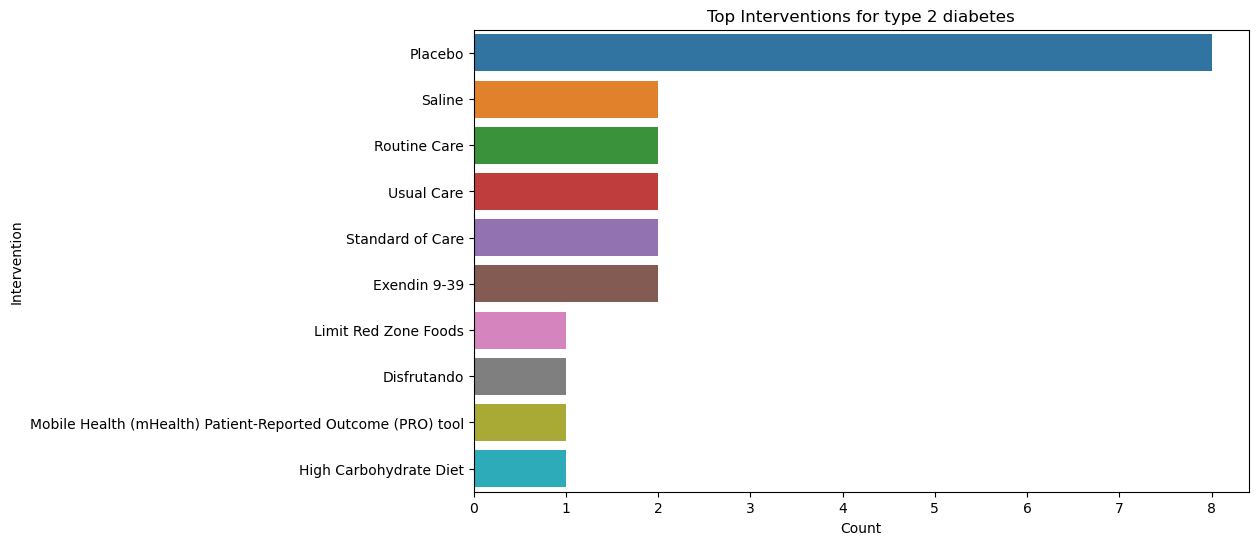

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_interventions.values, y=top_interventions.index)
plt.title("Top Interventions for type 2 diabetes")
plt.xlabel("Count")
plt.ylabel("Intervention")
plt.show()

#### Question: What does this graph tell us about the landscape of current clinical trials for T2D interventions?
The most common intervention is placebo, followed by other control-based approaches such as standard care, routine care, and usual care. This suggests that the majority of trials are designed as randomized controlled trials (RCTs). In contrast, branded or novel interventions appear less frequently and are highly diverse, indicating that there is no dominant experimental treatment and that the current research landscape is exploring a broad range of approaches beyond established controls.